# Projekt IAU  
## 1. časť - Prieskumná analýza 
### Vypracovali: Martin Kukučka, Martin Jankuliak

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import glob

import datetime
from datetime import datetime,date
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import json
import re
import dateutil.parser as parser
import statsmodels.api as sm

import scipy as sc
from pandas import read_csv


### Načítanie dát

In [74]:
df_other_train = read_csv("data/other_train.csv")
df_personal_train = read_csv("data/personal_train.csv")

## Základný opis dát spolu s ich charakteristikami 

### Dataset other_train.csv

Pre predstavu tu je ukážka datasetu

In [3]:
df_other_train.head()

,Unnamed: 0,name,address,race,marital-status,occupation,pregnant,education-num,relationship,capital-gain,education,fnlwgt,class,income,medical_info,native-country,hours-per-week,capital-loss,workclass
0,0,Robert Plante,"3594 Johnson Green Suite 277\r\nJohnsonport, V...",White,Widowed,Other-service,f,5.0,Unmarried,0.0,9th,220019.0,1.0,<=50K,"{'mean_glucose':'106.71875','std_glucose':'48....",United-States,9.0,0.0,Private
1,1,Richard Huey,"350 Lewis Haven\r\nAngelaton, IN 39486",Asian-Pac-Islander,Never-married,Handlers-cleaners,f,13.0,Not-in-family,0.0,Bachelors,196899.0,0.0,<=50K,"{'mean_glucose':'118.609375','std_glucose':'na...",Haiti,50.0,0.0,Private
2,2,Joseph Sable,22509 Adrian Canyon Suite 799\r\nEast Timothyt...,White,Never-married,Exec-managerial,f,9.0,Unmarried,0.0,HS-grad,301591.0,0.0,<=50K,"{'mean_glucose':'129.4609375','std_glucose':'5...",United-States,35.0,0.0,Private
3,3,Gregory Preston,"2674 Daryl Island\r\nLake Sean, TN 89363",White,Married-civ-spouse,Exec-managerial,f,13.0,Husband,0.0,Bachelors,310320.0,1.0,>50K,"{'mean_glucose':'30.1015625','std_glucose':'37...",United-States,40.0,0.0,Private
4,4,Mike Riley,023 Joseph Estate Suite 799\r\nLake Andrewvill...,White,Married-civ-spouse,Handlers-cleaners,f,9.0,Husband,0.0,HS-grad,237943.0,0.0,<=50K,"{'mean_glucose':'124.0390625','std_glucose':'4...",United-States,60.0,0.0,private


Pomocou tohto príkazu zistíme počet riadkov

In [4]:
df_other_train.shape[0]

3983

A teraz počet atribútov pre tento dataset

In [5]:
df_other_train.shape[1]

19

Typy atribútov zistíme týmto príkazom

In [6]:
df_other_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      3983 non-null   int64  
 1   name            3983 non-null   object 
 2   address         3983 non-null   object 
 3   race            3691 non-null   object 
 4   marital-status  3970 non-null   object 
 5   occupation      3961 non-null   object 
 6   pregnant        3969 non-null   object 
 7   education-num   3961 non-null   float64
 8   relationship    3954 non-null   object 
 9   capital-gain    3969 non-null   float64
 10  education       3972 non-null   object 
 11  fnlwgt          3968 non-null   float64
 12  class           3960 non-null   float64
 13  income          3972 non-null   object 
 14  medical_info    3966 non-null   object 
 15  native-country  3966 non-null   object 
 16  hours-per-week  3966 non-null   float64
 17  capital-loss    3973 non-null   f

Zistile sme, že tento dataset je zložený z atribútov:
- 6x float
- 1x int
- 12x object

Ďalej tu vidíme aj počet riadkov: 3983 ("RangeIndex: 3983 entries"),
a počet stĺpcov: 19 ("Data columns (total 19 columns)")

Nakoniec sa pozrieme na desktiptívne štatistiky.

In [7]:
df_other_train.describe()

,Unnamed: 0,education-num,capital-gain,fnlwgt,class,hours-per-week,capital-loss
count,3983.00000,3961.000000,3969.000000,3968.000000,3960.000000,3966.000000,3973.000000
mean,1991.00000,10.052764,1134.530108,189963.996976,0.256313,40.203984,72.926252
std,1149.93739,2.520019,8067.028170,102327.438172,0.436652,12.317838,360.910859
min,0.00000,1.000000,0.000000,20308.000000,0.000000,1.000000,0.000000
25%,995.50000,9.000000,0.000000,119475.250000,0.000000,40.000000,0.000000
50%,1991.00000,10.000000,0.000000,180585.500000,0.000000,40.000000,0.000000
75%,2986.50000,12.000000,0.000000,236173.000000,1.000000,45.000000,0.000000
max,3982.00000,16.000000,99999.000000,795830.000000,1.000000,99.000000,2824.000000


V tejto tabuľke vidíme ako sú: počet záznamov, priemer, štandardnú odchýlku, minimum, prvý kvartil, druhý kvartil (medián), tretí kvartil, maximum, pre všetky atribúty, ktoré obsahujú numerické hodnoty.

### Dataset personal_train.csv

Rovnako vykonáme opis dát aj pre druhý dataset

Ukážka datasetu

In [8]:
df_personal_train.head()

,Unnamed: 0,name,address,age,sex,date_of_birth
0,0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...",58,Male,1961-04-27
1,1,Ernest Kline,"391 Ball Road Suite 961\r\nFlowersborough, IN ...",43,Female,1976-09-12
2,2,Harold Hendriks,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",51,Male,1967-11-12
3,3,Randy Baptiste,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",66,Male,1953-06-02
4,4,Anthony Colucci,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...",45,Female,1974/09/11


Počet riadkov

In [9]:
df_personal_train.shape[0]

3933

Počet atribútov

In [10]:
df_personal_train.shape[1]

6

Typy atribútov

In [11]:
df_personal_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     3933 non-null   int64 
 1   name           3933 non-null   object
 2   address        3933 non-null   object
 3   age            3933 non-null   int64 
 4   sex            3933 non-null   object
 5   date_of_birth  3933 non-null   object
dtypes: int64(2), object(4)
memory usage: 184.5+ KB


Zistile sme, že tento dataset je zložený z atribútov:
- 2x int
- 4x object

Ďalej tu vidíme aj počet riadkov: 3933 ("RangeIndex: 3933 entries"),
a počet stĺpcov: 6 ("Data columns (total 6 columns)")

A Nakoniec desktiptívne štatistiky.

In [12]:
df_personal_train.describe()

,Unnamed: 0,age
count,3933.000000,3933.000000
mean,1966.000000,51.816934
std,1135.503633,11.814803
min,0.000000,-1.000000
25%,983.000000,44.000000
50%,1966.000000,52.000000
75%,2949.000000,60.000000
max,3932.000000,113.000000


## Párová analýza dát

Nacitanie datasetov a nahradenie pomlciek podtrznikmi

In [8]:
df_other_train_analysis = read_csv("data/other_train.csv")

df_other_train_analysis.columns = df_other_train_analysis.columns.str.replace('-','_')

# df_other_train_analysis.info()
# df_personal_train_analysis.info()

Premenovanie class na Pclass a vymazanie stlpca Unnamed: 0

In [5]:
df_other_train_analysis.rename(columns = {'class':'Pclass'}, inplace = True)
df_other_train_analysis = df_other_train_analysis.drop(columns=['Unnamed: 0'])

# df_other_train_analysis.head()

Zobrazenie numerickych hodnot

In [6]:
df_other_train_analysis.describe()

,education_num,capital_gain,fnlwgt,Pclass,hours_per_week,capital_loss
count,3961.000000,3969.000000,3968.000000,3960.000000,3966.000000,3973.000000
mean,10.052764,1134.530108,189963.996976,0.256313,40.203984,72.926252
std,2.520019,8067.028170,102327.438172,0.436652,12.317838,360.910859
min,1.000000,0.000000,20308.000000,0.000000,1.000000,0.000000
25%,9.000000,0.000000,119475.250000,0.000000,40.000000,0.000000
50%,10.000000,0.000000,180585.500000,0.000000,40.000000,0.000000
75%,12.000000,0.000000,236173.000000,1.000000,45.000000,0.000000
max,16.000000,99999.000000,795830.000000,1.000000,99.000000,2824.000000


Nacitanie hodnot zo stlpca medical_info do osobitneho data setu

In [7]:
data_frame = {}
med_inf = df_other_train_analysis.medical_info
med_inf = med_inf.str.replace("'", '"').tolist()
data_keys = json.loads(med_inf[0]).keys()

for data_key in data_keys:
    data_frame[data_key] = []

for data in med_inf:
    if isinstance(data, str):
        values = json.loads(data)
        for data_key in data_keys:
            data_frame[data_key].append(values[data_key])
    else:
        for data_key in data_keys:
            data_frame[data_key].append(np.NaN)

data_frame = pd.DataFrame(data_frame)

Zobrazenie prvych riadkov z noveho data setu

In [8]:
data_frame.head()

,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,106.71875,48.59991922,0.48313819,0.060911664,6.269230769,29.92992523,6.026227617999999,38.46886389
1,118.609375,nan,0.386486255,-0.391453476,6.880434782999999,31.45280882,4.726094845,22.1326697
2,129.4609375,51.84771908,0.097801521,-0.17631789,1.074414716,12.3100408,14.03786226,224.8662321
3,30.1015625,37.99585501,4.505472298,20.78517939,75.45234114,78.74218273,0.894009245,-0.437248907
4,124.0390625,46.68133365,0.113198941,0.403242952,5.68812709,26.33443057,5.662103534,35.99633243


Spojenie noveho data setu s povodnym a vymazanie stlpca medical_info

In [35]:
data_frame = pd.concat([df_other_train_analysis, data_frame.reindex(df_other_train_analysis.index)], axis=1)
data_frame = data_frame.drop(columns=['medical_info'])
data_frame.head()

,name,address,race,marital_status,occupation,pregnant,education_num,relationship,capital_gain,education,...,capital_loss,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,Robert Plante,"3594 Johnson Green Suite 277\r\nJohnsonport, V...",White,Widowed,Other-service,f,5.0,Unmarried,0.0,9th,...,0.0,Private,106.718750,48.599919,0.483138,0.060912,6.269231,29.929925,6.026228,38.468864
1,Richard Huey,"350 Lewis Haven\r\nAngelaton, IN 39486",Asian-Pac-Islander,Never-married,Handlers-cleaners,f,13.0,Not-in-family,0.0,Bachelors,...,0.0,Private,118.609375,NaN,0.386486,-0.391453,6.880435,31.452809,4.726095,22.132670
2,Joseph Sable,22509 Adrian Canyon Suite 799\r\nEast Timothyt...,White,Never-married,Exec-managerial,f,9.0,Unmarried,0.0,HS-grad,...,0.0,Private,129.460938,51.847719,0.097802,-0.176318,1.074415,12.310041,14.037862,224.866232
3,Gregory Preston,"2674 Daryl Island\r\nLake Sean, TN 89363",White,Married-civ-spouse,Exec-managerial,f,13.0,Husband,0.0,Bachelors,...,0.0,Private,30.101562,37.995855,4.505472,20.785179,75.452341,78.742183,0.894009,-0.437249
4,Mike Riley,023 Joseph Estate Suite 799\r\nLake Andrewvill...,White,Married-civ-spouse,Handlers-cleaners,f,9.0,Husband,0.0,HS-grad,...,0.0,private,124.039062,46.681334,0.113199,0.403243,5.688127,26.334431,5.662104,35.996332


Zobrazenie informacii o data sete

In [10]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3983 non-null   object 
 1   address           3983 non-null   object 
 2   race              3691 non-null   object 
 3   marital_status    3970 non-null   object 
 4   occupation        3961 non-null   object 
 5   pregnant          3969 non-null   object 
 6   education_num     3961 non-null   float64
 7   relationship      3954 non-null   object 
 8   capital_gain      3969 non-null   float64
 9   education         3972 non-null   object 
 10  fnlwgt            3968 non-null   float64
 11  Pclass            3960 non-null   float64
 12  income            3972 non-null   object 
 13  native_country    3966 non-null   object 
 14  hours_per_week    3966 non-null   float64
 15  capital_loss      3973 non-null   float64
 16  workclass         3966 non-null   object 


Hodnoty, ktore su typu object pretypujeme na float

In [11]:
data_frame.mean_glucose = data_frame.mean_glucose.astype(float)
data_frame.std_glucose = data_frame.std_glucose.astype(float)
data_frame.kurtosis_glucose = data_frame.kurtosis_glucose.astype(float)
data_frame.skewness_glucose = data_frame.skewness_glucose.astype(float)
data_frame.mean_oxygen = data_frame.mean_oxygen.astype(float)
data_frame.std_oxygen = data_frame.std_oxygen.astype(float)
data_frame.kurtosis_oxygen = data_frame.kurtosis_oxygen.astype(float)
data_frame.skewness_oxygen = data_frame.skewness_oxygen.astype(float)

Zobrazenie korelacie medzi jednotlivymi stlpcami

In [12]:
data_frame.corr()

,education_num,capital_gain,fnlwgt,Pclass,hours_per_week,capital_loss,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
education_num,1.000000,0.123889,-0.021473,-0.016022,0.145341,0.073644,0.010980,-0.003644,-0.002776,0.003668,-0.033308,-0.015143,0.002141,-0.013038
capital_gain,0.123889,1.000000,-0.004133,-0.004884,0.062525,-0.028330,0.013889,-0.017045,-0.013238,-0.011348,-0.010286,-0.002061,-0.003900,-0.010917
fnlwgt,-0.021473,-0.004133,1.000000,-0.008495,-0.019431,0.001739,0.021942,-0.046924,-0.016319,-0.017772,-0.000699,0.006683,-0.020806,-0.026493
Pclass,-0.016022,-0.004884,-0.008495,1.000000,-0.018250,0.014470,-0.774796,0.012411,0.788009,0.680492,0.517517,0.649252,-0.557858,-0.392099
hours_per_week,0.145341,0.062525,-0.019431,-0.018250,1.000000,0.062131,-0.000500,0.025705,0.004497,0.006531,0.000154,0.012247,-0.011479,-0.009528
capital_loss,0.073644,-0.028330,0.001739,0.014470,0.062131,1.000000,-0.023089,0.003752,0.023071,0.022763,0.004634,0.013276,-0.019131,-0.018075
mean_glucose,0.010980,0.013889,0.021942,-0.774796,-0.000500,-0.023089,1.000000,-0.004324,-0.925903,-0.826277,-0.543524,-0.560976,0.474864,0.309581
std_glucose,-0.003644,-0.017045,-0.046924,0.012411,0.025705,0.003752,-0.004324,1.000000,0.007416,0.006021,-0.016831,0.007899,-0.012920,-0.015565
kurtosis_glucose,-0.002776,-0.013238,-0.016319,0.788009,0.004497,0.023071,-0.925903,0.007416,1.000000,0.961956,0.594013,0.619777,-0.529232,-0.347260
skewness_glucose,0.003668,-0.011348,-0.017772,0.680492,0.006531,0.022763,-0.826277,0.006021,0.961956,1.000000,0.548871,0.556852,-0.477737,-0.311959


Vizualizovane vztahy medzi datami

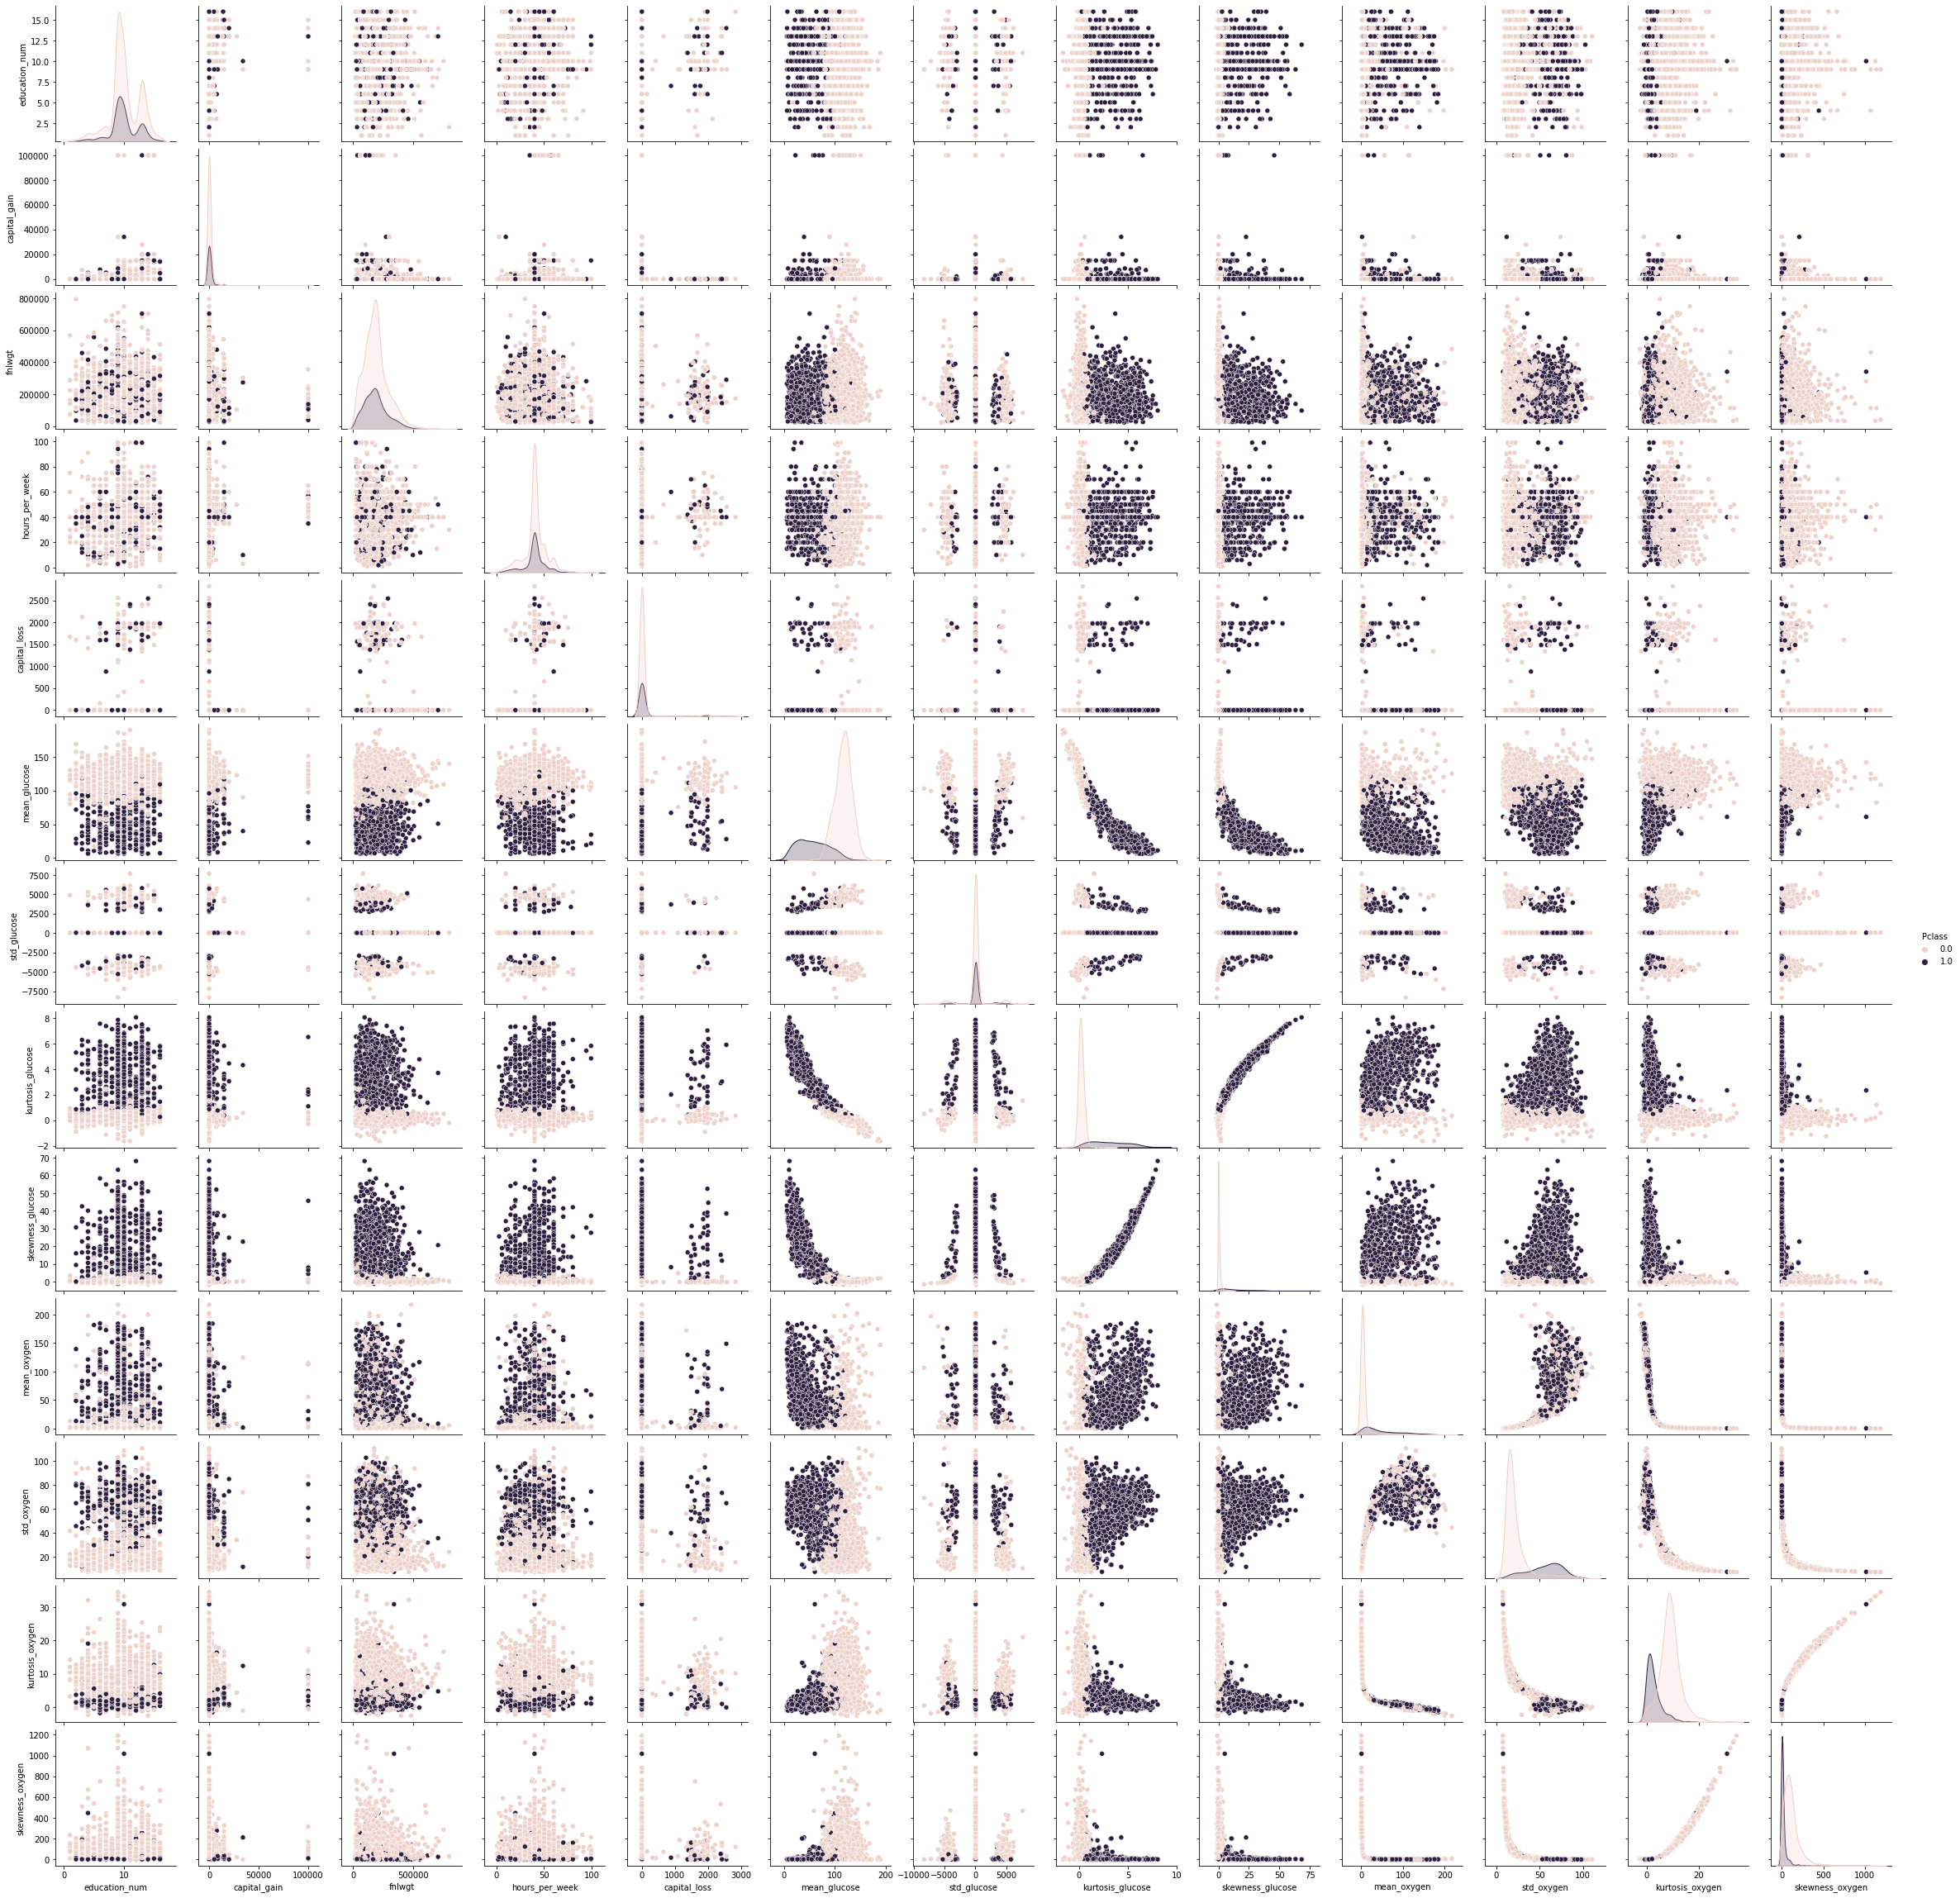

In [13]:
sns.pairplot(data_frame, hue="Pclass")

Tieto data by sa dali zobrazit na grafe jednej funkcie, cize vieme povedat, ze je medzi nimi zavislost

<AxesSubplot:xlabel='kurtosis_glucose', ylabel='skewness_glucose'>

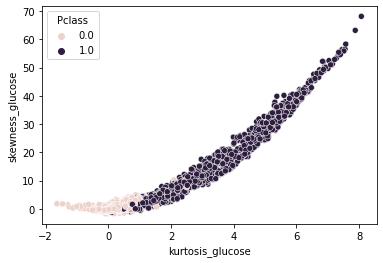

In [13]:
sns.scatterplot(x="kurtosis_glucose", y="skewness_glucose",hue="Pclass", data=data_frame)

Vypocitana Pearsonova korelacia, ktora je velmi vysoka cize tieto atributy su na sebe zavisle

Pearson correlation: 0.962


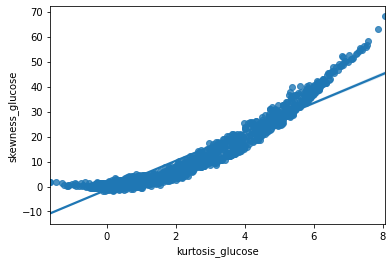

In [14]:
sns.regplot(x="kurtosis_glucose", y="skewness_glucose", data=data_frame)
print("Pearson correlation: %.3f" % data_frame.kurtosis_glucose.corr(data_frame.skewness_glucose))

Na boxplotoch nizsie je jasne vidno, ze chori ludia maju vyssie hodnoty kurtosis_glucose a skewness_glucose ako zdravi ludia

c:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Pclass', ylabel='kurtosis_glucose'>

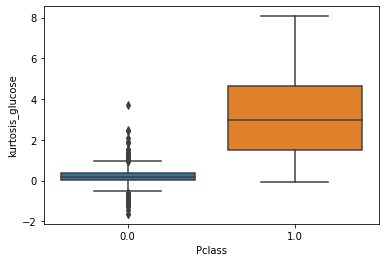

In [15]:
sns.boxplot('Pclass', 'kurtosis_glucose', data=data_frame)

c:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Pclass', ylabel='skewness_glucose'>

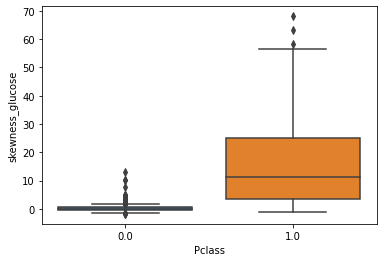

In [16]:
sns.boxplot('Pclass', 'skewness_glucose', data=data_frame)

Tieto data by sa tiez dali zobrazit na grafe jednej funkcie, cize vieme povedat, ze je medzi nimi zavislost

<AxesSubplot:xlabel='kurtosis_oxygen', ylabel='skewness_oxygen'>

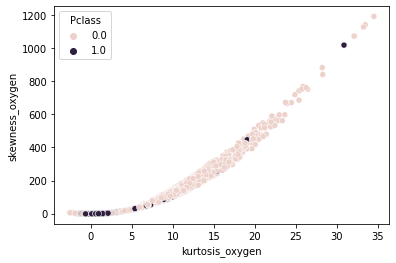

In [17]:
sns.scatterplot(x="kurtosis_oxygen", y="skewness_oxygen",hue="Pclass", data=data_frame)

Vypocitana Pearsonova korelacia, ktora je velmi vysoka cize tieto atributy su na sebe zavisle

Pearson correlation: 0.917


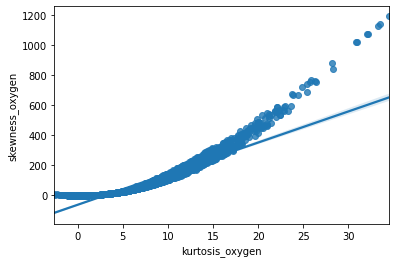

In [22]:
sns.regplot(x="kurtosis_oxygen", y="skewness_oxygen", data=data_frame)
print("Pearson correlation: %.3f" % data_frame.kurtosis_oxygen.corr(data_frame.skewness_oxygen))

Na boxplotoch nizsie je jasne vidno, ze chori ludia maju nizsie hodnoty kurtosis_oxygen a skewness_oxygen ako zdravi ludia

c:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Pclass', ylabel='kurtosis_oxygen'>

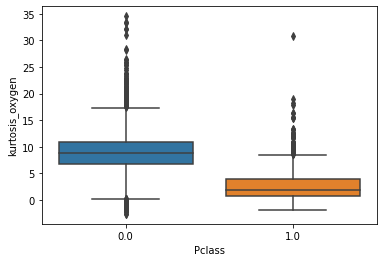

In [19]:
sns.boxplot('Pclass', 'kurtosis_oxygen', data=data_frame)

c:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Pclass', ylabel='skewness_oxygen'>

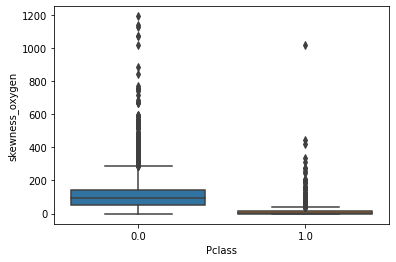

In [20]:
sns.boxplot('Pclass', 'skewness_oxygen', data=data_frame)

Tieto atributy pravdepodobne na sebe zavisle nebudu, ale mozme pozorovat rozdelenie na 2 zhluky, co bude tiez viest k nejakemu zaveru. Je vidiet, ze chori ludia maju vyssie hodnoty krutosis glucose a nizsie hodnoty skewness_oxygen.

<AxesSubplot:xlabel='kurtosis_glucose', ylabel='skewness_oxygen'>

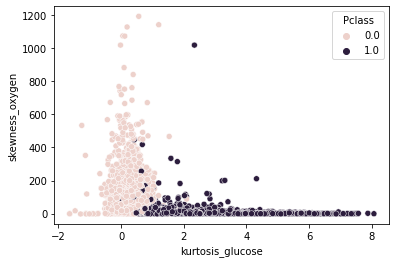

In [23]:
sns.scatterplot(x="kurtosis_glucose", y="skewness_oxygen",hue="Pclass", data=data_frame)

Je vidno, ze aj korelacia medzi tymito atributmi je slabsia

Pearson correlation: -0.347


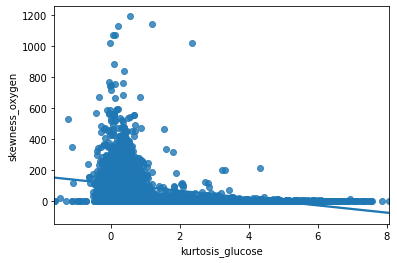

In [24]:
sns.regplot(x="kurtosis_glucose", y="skewness_oxygen", data=data_frame)
print("Pearson correlation: %.3f" % data_frame.kurtosis_glucose.corr(data_frame.skewness_oxygen))

Na boxplote je ale pekne vidno, ze je to pravda

c:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Pclass', ylabel='kurtosis_glucose'>

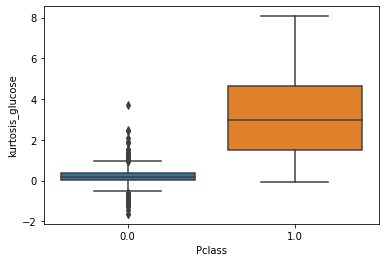

In [27]:
sns.boxplot('Pclass', 'kurtosis_glucose', data=data_frame)

Data, ktore su tu su velmi chaoticky rozhadzane a pravdepodobne nebudu mat ziadnu zavislost.

<AxesSubplot:xlabel='education_num', ylabel='kurtosis_oxygen'>

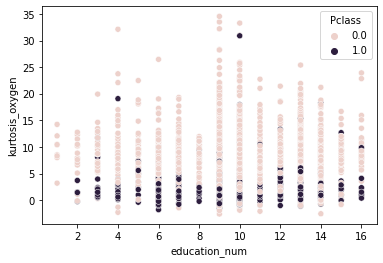

In [26]:
sns.scatterplot(x="education_num", y="kurtosis_oxygen",hue="Pclass", data=data_frame)

Podla korelacie vieme na isto povedat, ze atributy na sebe nezavisia.

Pearson correlation: 0.002


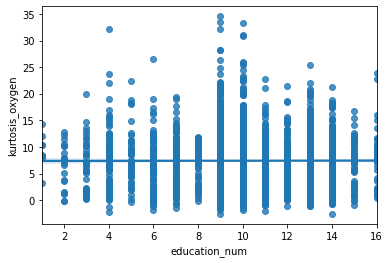

In [28]:
sns.regplot(x="education_num", y="kurtosis_oxygen", data=data_frame)
print("Pearson correlation: %.3f" % data_frame.education_num.corr(data_frame.kurtosis_oxygen))

Aj boxploty vyzeraju rovnako, cize nevieme z nich povedat jednoznacny zaver.

c:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Pclass', ylabel='education_num'>

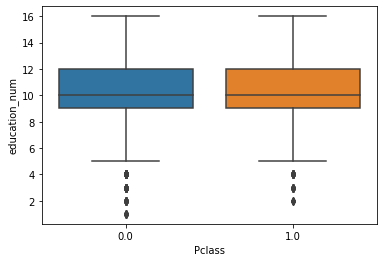

In [29]:
sns.boxplot('Pclass', 'education_num', data=data_frame)

Vykreslime si heatmapu, kde presne vidime podla farby, ktore atributy su zavisle

<AxesSubplot:>

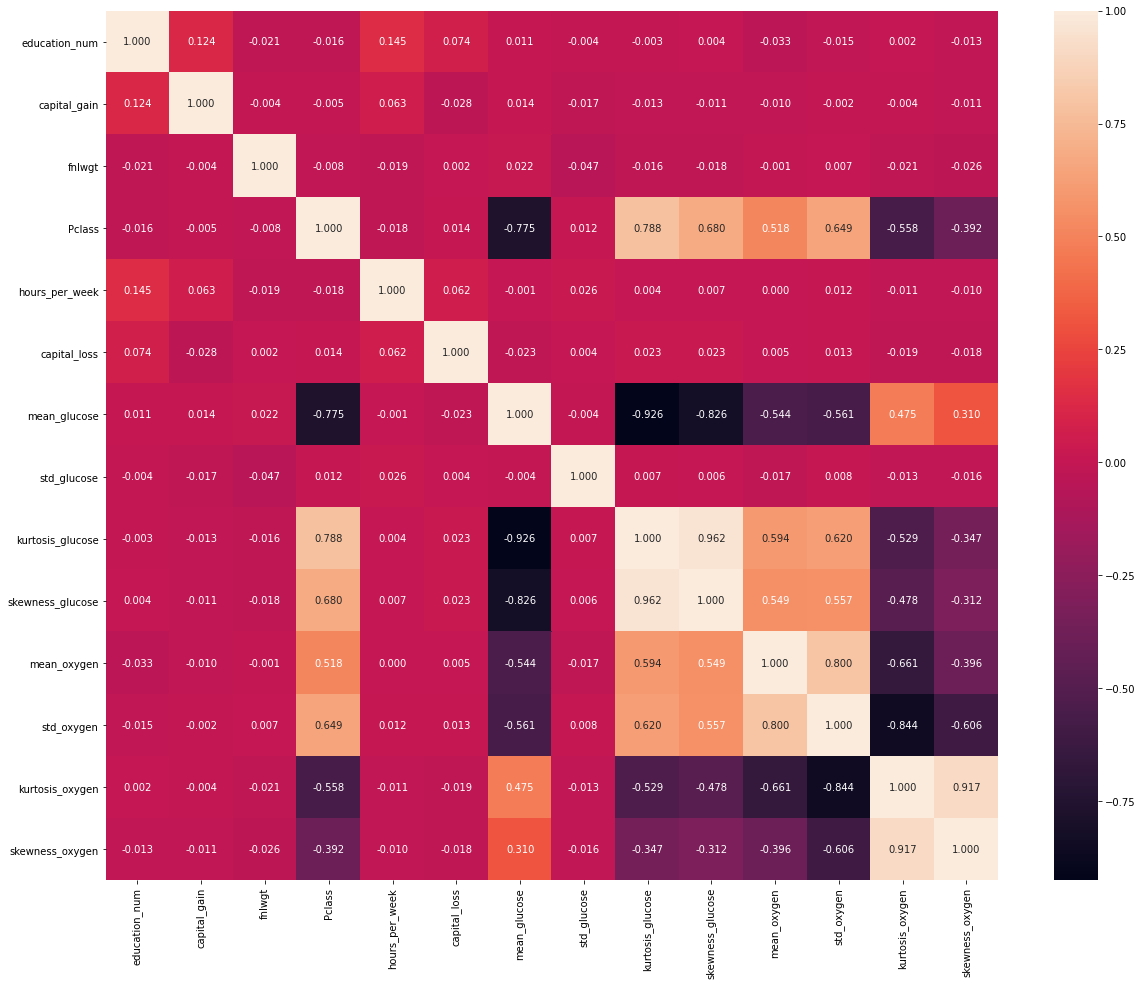

In [96]:
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(data_frame.corr(), ax=ax, annot=True, fmt=".3f")

Zobrazenie ludi s cukrovkov podla rasy

In [85]:
dia_race = pd.crosstab(index=data_frame["Pclass"], columns=data_frame["race"])
dia_race.index= ["0","1"]
dia_race

race,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White,??
0,29,84,246,19,2272,94
1,9,30,75,11,776,31


In [89]:
dia_race_perc = pd.crosstab(index=data_frame["Pclass"], 
                                  columns=data_frame["race"],
                                  normalize='columns')
dia_race_perc.index= ["0","1"]
dia_race_perc

race,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White,??
0,0.763158,0.736842,0.766355,0.633333,0.745407,0.752
1,0.236842,0.263158,0.233645,0.366667,0.254593,0.248


Zobrazenie ludi s cukrovkou podla zamestnania

In [30]:
dia_workclass = pd.crosstab(index=data_frame["Pclass"], columns=data_frame["workclass"])
dia_workclass.index= ["0","1"]
dia_workclass

workclass,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,?,federal-gov,local-gov,private,self-emp-inc,self-emp-not-inc,state-gov
0,145,67,158,1,1856,99,218,102,1,11,8,19,206,14,21,9
1,56,32,67,0,632,27,56,35,1,7,0,8,69,3,13,4


In [31]:
dia_workclass_perc = pd.crosstab(index=data_frame["Pclass"], 
                                  columns=data_frame["workclass"],
                                  normalize='columns')
dia_workclass_perc.index= ["0","1"]
dia_workclass_perc

workclass,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,?,federal-gov,local-gov,private,self-emp-inc,self-emp-not-inc,state-gov
0,0.721393,0.676768,0.702222,1.0,0.745981,0.785714,0.79562,0.744526,0.5,0.611111,1.0,0.703704,0.749091,0.823529,0.617647,0.692308
1,0.278607,0.323232,0.297778,0.0,0.254019,0.214286,0.20438,0.255474,0.5,0.388889,0.0,0.296296,0.250909,0.176471,0.382353,0.307692


### Vzorka 2

Nacitanie druhej vzorky, podobne ako tej prvej

In [12]:
df_personal_train_analysis = read_csv("data/personal_train.csv")
df_personal_train_analysis.columns = df_personal_train_analysis.columns.str.replace('-','_')
df_personal_train_analysis = df_personal_train_analysis = df_personal_train_analysis.drop(columns=['Unnamed: 0'])
df_personal_train_analysis.head()

,name,address,age,sex,date_of_birth
0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...",58,Male,1961-04-27
1,Ernest Kline,"391 Ball Road Suite 961\r\nFlowersborough, IN ...",43,Female,1976-09-12
2,Harold Hendriks,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",51,Male,1967-11-12
3,Randy Baptiste,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",66,Male,1953-06-02
4,Anthony Colucci,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...",45,Female,1974/09/11


In [13]:
df_personal_train_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           3933 non-null   object
 1   address        3933 non-null   object
 2   age            3933 non-null   int64 
 3   sex            3933 non-null   object
 4   date_of_birth  3933 non-null   object
dtypes: int64(1), object(4)
memory usage: 153.8+ KB


## Identifikácia problémov v dátach spolu s predpokladaným scenárom riešenia v ďalšej fáze

In [13]:
df_other_train[df_other_train.duplicated()]

,Unnamed: 0,name,address,race,marital-status,occupation,pregnant,education-num,relationship,capital-gain,education,fnlwgt,class,income,medical_info,native-country,hours-per-week,capital-loss,workclass


In [14]:
df_personal_train[df_personal_train.duplicated()]

,Unnamed: 0,name,address,age,sex,date_of_birth


In [15]:
df_other_train[df_other_train.name.isin(df_other_train.name[df_other_train.name.duplicated()])].sort_values(by=['name'])

,Unnamed: 0,name,address,race,marital-status,occupation,pregnant,education-num,relationship,capital-gain,education,fnlwgt,class,income,medical_info,native-country,hours-per-week,capital-loss,workclass
2078,2078,Alex Stubblefield,"PSC 1476, Box 5156\r\nAPO AE 20184",White,Married-civ-spouse,Protective-serv,FALSE,10.0,Husband,0.0,Some-college,194417.0,NaN,>50K,"{'mean_glucose':'39.3046875','std_glucose':'42...",United-States,40.0,0.0,Local-gov
2682,2682,Alex Stubblefield,"PSC 1476, Box 5156\r\nAPO AE 20184",NaN,Married-civ-spouse,NaN,FALSE,10.0,Husband,0.0,Some-college,NaN,1.0,>50K,"{'mean_glucose':'39.3046875','std_glucose':'42...",United-States,40.0,0.0,Local-gov
2416,2416,Ashley Lyons,"4166 Sara Points\r\nHernandezview, WY 62853",White,Married-civ-spouse,Handlers-cleaners,f,9.0,Husband,NaN,HS-grad,155972.0,NaN,>50K,NaN,United-States,40.0,0.0,Private
467,467,Ashley Lyons,"4166 Sara Points\r\nHernandezview, WY 62853",White,Married-civ-spouse,NaN,f,9.0,Husband,0.0,HS-grad,NaN,0.0,>50K,"{'mean_glucose':'111.1953125','std_glucose':'4...",United-States,NaN,0.0,Private
2553,2553,Billy Clark,"3859 Melissa Bridge Apt. 723\r\nShawnfurt, GA ...",White,Divorced,Exec-managerial,f,9.0,Not-in-family,NaN,HS-grad,195516.0,0.0,<=50K,"{'mean_glucose':'103.8046875','std_glucose':'4...",United-States,40.0,0.0,Local-gov
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,2845,William Ortiz,"11967 Melissa Squares\r\nEast Robin, DE 65168",Black,Separated,Other-service,f,12.0,NaN,0.0,Assoc-acdm,285865.0,0.0,<=50K,"{'mean_glucose':'116.734375','std_glucose':'51...",United-States,32.0,0.0,NaN
2025,2025,William Smith,045 Johnson Mountain Suite 137\r\nCourtneyland...,Amer-Indian-Eskimo,NaN,Prof-specialty,f,10.0,Husband,NaN,NaN,140474.0,0.0,<=50K,NaN,United-States,NaN,0.0,Private
2009,2009,William Smith,045 Johnson Mountain Suite 137\r\nCourtneyland...,Amer-Indian-Eskimo,Married-civ-spouse,Prof-specialty,f,10.0,Husband,0.0,Some-college,NaN,0.0,<=50K,"{'mean_glucose':'107.828125','std_glucose':'46...",United-States,40.0,0.0,Private
3806,3806,William Sullivan,"09205 Miller Locks Apt. 585\r\nPowellland, IN ...",White,Married-civ-spouse,Exec-managerial,f,10.0,NaN,0.0,Some-college,80324.0,0.0,NaN,"{'mean_glucose':'109.5625','std_glucose':'44.9...",NaN,62.0,1977.0,Private
